In [1]:
import numpy as np
import random
from copy import deepcopy
import networkx as nx
from matplotlib import pyplot as plt
import itertools
import timeit

In [2]:
def euclid_distance(u_x: float,
                    u_y: float,
                    v_x: float,
                    v_y: float) -> float:
    return np.sqrt((u_x - v_x)**2 + (u_y - v_y)**2)

In [3]:
def load_data(file_path: str) -> nx.Graph:
    with open(file_path, 'r') as f:
        g = nx.Graph()
        for line in f:
            if line[0].isdigit():
                node_id, x, y = [float(a) for a in line.split()]
                g.add_node(int(node_id) - 1, x=x, y=y)
        
        for u in range(len(g.nodes)):
            for v in range(u + 1, len(g.nodes)):
                
                weight = euclid_distance(g.nodes[u]['x'],
                                        g.nodes[u]['y'],
                                        g.nodes[v]['x'],
                                        g.nodes[v]['y'])
                
                g.add_edge(u, v, weight=weight)
                
        return g

In [4]:
def load_data_rs(file_path: str) -> nx.Graph:
    with open(file_path, 'r') as f:
        g = nx.Graph()
        for line in f:
            if line[0].isdigit():
                node_id, x, y, name, lp = [a for a in line.split()]
                
                g.add_node(int(node_id) - 1, x=float(x), y=float(y), name=name, lp=lp)
        
        for u in range(len(g.nodes)):
            for v in range(u + 1, len(g.nodes)):
                
                weight = euclid_distance(g.nodes[u]['x'],
                                        g.nodes[u]['y'],
                                        g.nodes[v]['x'],
                                        g.nodes[v]['y'])
                
                g.add_edge(u, v, weight=weight)
                
        return g

In [5]:
class Hamiltonian: 
    def __init__(self, g : nx.Graph):
        self.graph = deepcopy(g)
        self.cycle, self.fitness = self.initialize()

    def initialize(self):
        start = 0
        cycle = [start]
        visited = {start}
        u = start
        cycle_weight = 0
        g = self.graph
        
        while len(visited) != len(g.nodes):
            neighbours = [v for v in g[u] if v not in visited]
            chosen_neighbour = random.choices(neighbours, weights=None, k=1)[0]
            cycle.append(chosen_neighbour)
            visited.add(chosen_neighbour)
            cycle_weight += g[u][chosen_neighbour]['weight']
            u = chosen_neighbour
        
        cycle_weight += g[start][cycle[-1]]['weight']
        
        return cycle, cycle_weight
        
    def calcFitness(self):
        fitness = self.graph[self.cycle[0]][self.cycle[-1]]['weight']
        for u, v in zip(self.cycle[:-1], self.cycle[1:]):
            fitness += self.graph[u][v]['weight']
        self.fitness = fitness
        
    def bruteForce(self):
        best_fitness = self.fitness
        best_cycle = self.cycle
        permutations = itertools.permutations(self.cycle)
        
        for cycle in permutations:
            fitness = self.graph[cycle[0]][cycle[-1]]['weight']
            for u, v in zip(cycle[:-1], cycle[1:]):
                fitness += self.graph[u][v]['weight']
            
            if fitness < best_fitness:
                best_fitness = fitness
                best_cycle = cycle
        
        self.cycle = best_cycle
        self.fitness = best_fitness
        
        
    def __str__(self):
        return ' '.join([str(u) for u in self.cycle]) + f' {self.fitness}'
    
    def __getitem__(self, index):
        return self.cycle[index]

In [6]:
class SimulatedAnnealing(Hamiltonian):
    def __init__(self, graph : nx.Graph):
        super().__init__(graph)
    
    def swap(self): #swap place of two random cities
        a = random.randrange(len(self.cycle))
        b = random.randrange(len(self.cycle))
        
        self.cycle[a], self.cycle[b] = self.cycle[b], self.cycle[a]
        
        self.calcFitness()
    
    def optimizeMinusT(self,
                 num_iters: int,
                 end_fitness: float #0 if unknown
                 ):

        best_cycle = deepcopy(self.cycle)
        best_fitness = self.fitness
        fitnesses = [self.fitness]
        it = 1
        
        while (it < num_iters+1) and (end_fitness == 0 or (np.abs(best_fitness - end_fitness) > 0.1)):
            
            oldCycle, oldFitness = deepcopy(self.cycle), self.fitness
            self.swap()
            
            r = random.random()
            
            if self.fitness < oldFitness:
                if self.fitness < best_fitness:
                    best_fitness = self.fitness
                    best_cycle = deepcopy(self.cycle) #TODO optimize
            elif r > 1 / it:
                self.cycle = deepcopy(oldCycle)
                self.fitness = oldFitness
            
            
            fitnesses.append(best_fitness)
            #temperatures.append(temperature)
            it+=1
        
        
        self.cycle = deepcopy(best_cycle)
        self.fitness = best_fitness
        
        return fitnesses
            
    def optimize(self,
                 num_iters: int, 
                 T0: float,
                 fast_annealing: bool,
                 end_fitness: float, # 0 if unknown
                 ):

        best_cycle = deepcopy(self.cycle)
        best_fitness = self.fitness
        fitnesses = [self.fitness]
        #temperatures = [T0]
        temperature = T0
        it = 2
        
        while (it < num_iters+2) and (end_fitness == 0 or (np.abs(best_fitness - end_fitness) > 0.1)):
            
            oldCycle, oldFitness = deepcopy(self.cycle), self.fitness
            self.swap()
            
            r = random.random()
            
            if self.fitness < oldFitness:
                if self.fitness < best_fitness:
                    best_fitness = self.fitness
                    best_cycle = deepcopy(self.cycle) #TODO optimize
            elif r > np.exp(-(self.fitness - oldFitness) / temperature):
                self.cycle = deepcopy(oldCycle)
                self.fitness = oldFitness
            
            if fast_annealing == True:
                temperature = T0/it
            else:
                temperature = T0/np.log(it)
            
            fitnesses.append(best_fitness)
            #temperatures.append(temperature)
            
            it+=1
        
        self.cycle = deepcopy(best_cycle)
        self.fitness = best_fitness
        
        return fitnesses

In [7]:
class AdaptiveSimulatedAnnealing(Hamiltonian):
    def __init__(self, graph : nx.Graph):
        super().__init__(graph)
        
        
        self.setTuningParameters()
        self.initializeParameters()
        
    def setTuningParameters(self):  
        
        self.maxIters = 1000000
        self.reannealingRate = 10
        
        #Inberg defalut values
        self.temperature_ratio_scale = 0.00001
        self.temperature_anneal_scale = 100.0
        
        self.calculatec()
        
    
    def calculatec(self):
        
        self.m = -np.log(self.temperature_ratio_scale)
        self.n = np.log(self.temperature_anneal_scale)
        
        self.c = self.m * np.exp(-self.n / len(self.cycle))
    
    def initializeParameters(self):
        
        self.T0 = self.fitness
        self.Tcost = self.fitness
        self.Ti0 = [self.fitness] * len(self.cycle) #probabilities for sorted sequence, not generated
        self.Ti = [self.fitness] * len(self.cycle)
        
        self.acceptedPoints = 0 #k_cost in doc
        self.generatedPoints = [0] * len(self.cycle) #k_i in doc
        self.delta = [1] * len(self.cycle)
        
        self.best_cycle = deepcopy(self.cycle)
        self.best_fitness = self.fitness
    
    def swap(self): #swap place of two random cities
        
        a, b = random.choices(range(len(self.cycle)), weights = self.Ti, k=2)
        
        self.generatedPoints[a] += 1
        self.generatedPoints[b] += 1
        
        self.Ti[a] = self.Ti0[a] * np.exp(-self.c * self.generatedPoints[a]**(1 / len(self.cycle)))
        self.Ti[b] = self.Ti0[b] * np.exp(-self.c * self.generatedPoints[b]**(1 / len(self.cycle)))
        
        self.cycle[a], self.cycle[b] = self.cycle[b], self.cycle[a]
        
        self.calcFitness()
        
        return a, b
        
    
    def reannealing(self):
        self.fitness = self.best_fitness
        self.cycle = deepcopy(self.best_cycle)
        
        deltaMax = max(self.delta)
        
        for i in range(len(self.Ti)):
            if self.delta[i] >= 0.000001:
                self.Ti[i] = self.Ti[i]*(deltaMax/self.delta[i])
                
        for i in range(len(self.generatedPoints)):
            self.generatedPoints[i] = (np.log(self.Ti0[i]/self.Ti[i])/self.c)**len(self.cycle)
        
        #self.generatedPoints = [1] * len(self.cycle)
        
        self.acceptedPoints = 1
        self.T0 = Tcost = self.fitness 
        
        self.delta = [1] * len(self.cycle)
        
        
    
    def optimize(self, 
                 end_fitness : float #0 if it is unknown
                ): 

        fitnesses = []
        #temperatures = []
        
        self.initializeParameters()
        it = 1
        
        while (it < self.maxIters+1) and (end_fitness == 0 or (np.abs(self.best_fitness - end_fitness) > 0.1)):
            
            if self.acceptedPoints % self.reannealingRate == 0:
                self.reannealing()
                
            oldCycle, oldFitness = deepcopy(self.cycle), self.fitness
            
            a, b = self.swap()
            
            r = random.random()
            
            if self.fitness < oldFitness:

                self.acceptedPoints += 1
                self.Tcost = self.T0 * np.exp(-self.c * self.acceptedPoints**(1 / len(self.cycle)))
                self.delta[a] = self.delta[b] = oldFitness - self.fitness 
                
                if self.fitness < self.best_fitness:
                    
                    self.best_fitness = self.fitness
                    self.best_cycle = deepcopy(self.cycle) 
            
            elif r < (np.exp(-(self.fitness - oldFitness)/self.Tcost)):
                
                self.acceptedPoints += 1
                self.Tcost = self.T0 * np.exp(-self.c * self.acceptedPoints**(1 / len(self.cycle)))
            
            else:
                
                self.cycle = deepcopy(oldCycle)
                self.fitness = oldFitness
            

            fitnesses.append(self.best_fitness)
            #temperatures.append(self.Tcost)
            
            it+=1
        
        self.cycle = deepcopy(self.best_cycle)
        self.fitness = self.best_fitness
        
        return fitnesses

In [8]:
def draw(g : nx.Graph,
         c : Hamiltonian,
         rs : bool): #tested
    edgeList = []
    for i in range(len(c.cycle)-1):
        edgeList.append((c.cycle[i], c.cycle[i+1]))
    edgeList.append((c.cycle[0], c.cycle[-1]))
    pos = {}
    labels = {}
    for u in g.nodes:
        x = g.nodes[u]['x'] /1000
        y = g.nodes[u]['y'] /1000
        pos[u] = (x,y)
        if rs:
            labels[u] = g.nodes[u]['lp']
        else:
            labels[u] = u
        
    nx.draw(g, edgelist = edgeList, pos=pos, labels = labels, with_labels = True, node_size=500,
            node_color='black', width=3, font_color = 'white', node_shape='o' )

In [14]:
rs5 = load_data_rs(file_path='rs5.tsp')
rs10 = load_data_rs(file_path='rs10.tsp')
rs15 = load_data_rs(file_path='rs15.tsp')

In [15]:
bruteforce5 = SimulatedAnnealing(rs5)
bruteforce10 = SimulatedAnnealing(rs10)
bruteforce15 = AdaptiveSimulatedAnnealing(rs15)

In [16]:
start = timeit.default_timer()
bruteforce5.bruteForce()
stop = timeit.default_timer()
print(f'Best cycle:{bruteforce5.cycle}\nBest fitness:{bruteforce5.fitness}\nTime:{stop-start}')

Best cycle:(2, 3, 1, 4, 0)
Best fitness:7287.430630882176
Time:0.00047866500972304493


In [17]:
start = timeit.default_timer()
bruteforce10.bruteForce()
stop = timeit.default_timer()
print(f'Best cycle:{bruteforce10.cycle}\nBest fitness:{bruteforce10.fitness}\nTime:{stop-start}')

Best cycle:(2, 7, 3, 6, 4, 1, 0, 8, 9, 5)
Best fitness:8799.828958445938
Time:22.987893402998452


In [18]:
bruteforce15.maxIters = 1000000
bruteforce15res = bruteforce15.optimize(0)

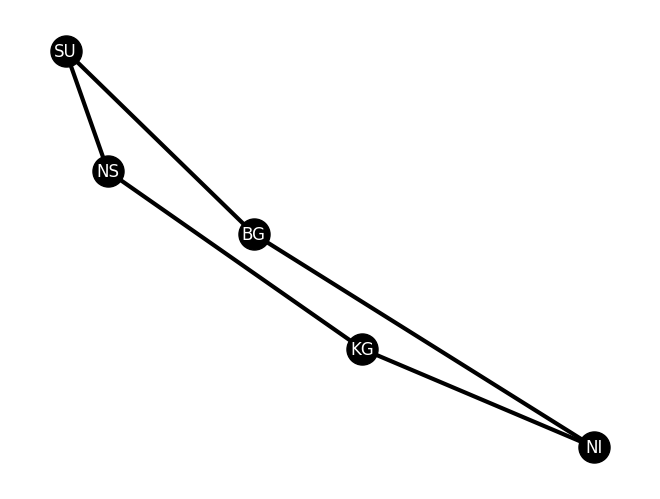

In [19]:
draw(g=rs5, c=bruteforce5, rs=True)

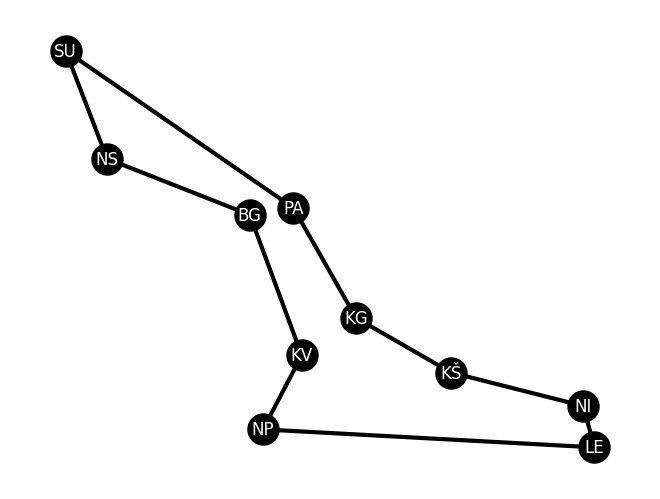

In [20]:
draw(g=rs10, c=bruteforce10, rs=True)

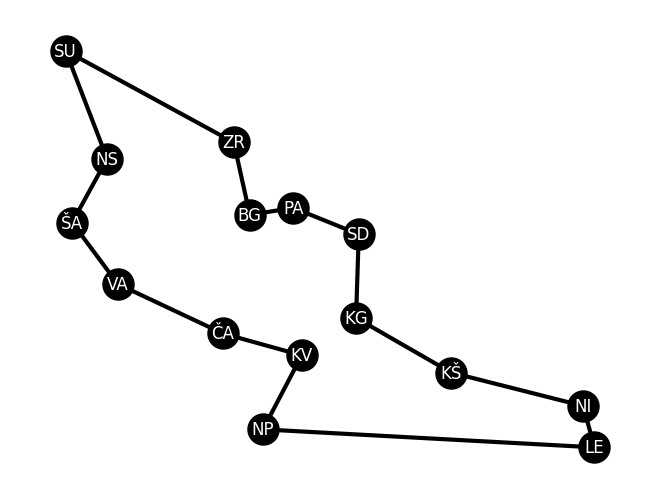

In [37]:
draw(g=rs15, c=bruteforce15, rs=True)

In [38]:
print(bruteforce15.fitness)

9254.30825070286


In [13]:
#Require 3months to compute
#start = timeit.default_timer()
#bruteforce15.bruteForce()
#stop = timeit.default_timer()
#print(f'Best cycle:{bruteforce15.cycle}\nBest fitness:{bruteforce15.fitness}\nTime:{stop-start}')

In [333]:
osnovni5 = SimulatedAnnealing(rs5)
osnovni10 = SimulatedAnnealing(rs10)
osnovni15 = SimulatedAnnealing(rs15)

In [278]:
start = timeit.default_timer()
osnovni5res = osnovni5.optimizeMinusT(num_iters=10000, end_fitness=7287.43)
stop = timeit.default_timer()
print(f'Best cycle:{osnovni5.cycle}\nBest fitness:{osnovni5.fitness}\nTime:{stop-start}')

Best cycle:[0, 4, 1, 3, 2]
Best fitness:7287.430630882177
Time:0.00017038400983437896


In [334]:
start = timeit.default_timer()
osnovni10res = osnovni10.optimizeMinusT(num_iters=10000000, end_fitness=8799.828)
stop = timeit.default_timer()
print(f'Best cycle:{osnovni10.cycle}\nBest fitness:{osnovni10.fitness}\nTime:{stop-start}')

Best cycle:[9, 8, 0, 1, 4, 6, 3, 7, 2, 5]
Best fitness:8799.82895844594
Time:0.0846081210183911


In [199]:
start = timeit.default_timer()
osnovni15res = osnovni15.optimizeMinusT(num_iters=10000000, end_fitness=9254.308)
stop = timeit.default_timer()
print(f'Best cycle:{osnovni15.cycle}\nBest fitness:{osnovni15.fitness}\nTime:{stop-start}')

Best cycle:[2, 7, 3, 13, 6, 0, 10, 4, 1, 12, 14, 11, 8, 9, 5]
Best fitness:9254.308250702858
Time:12.095940629951656


In [93]:
boltzmann5 = SimulatedAnnealing(rs5)
boltzmann10 = SimulatedAnnealing(rs10)
boltzmann15 = SimulatedAnnealing(rs15)

In [88]:
start = timeit.default_timer()
boltzmann5res=boltzmann5.optimize(num_iters=100000, T0=7287.43, fast_annealing=False, end_fitness=7287.43)
stop = timeit.default_timer()
print(f'Best cycle:{boltzmann5.cycle}\nBest fitness:{boltzmann5.fitness}\nTime:{stop-start}')

Best cycle:[4, 1, 3, 2, 0]
Best fitness:7287.430630882176
Time:0.00030805799178779125


In [99]:
start = timeit.default_timer()
boltzmann10res=boltzmann10.optimize(num_iters=10000000, T0=8799.828, fast_annealing=False, end_fitness=8799.828)
stop = timeit.default_timer()
print(f'Best cycle:{boltzmann10.cycle}\nBest fitness:{boltzmann10.fitness}\nTime:{stop-start}')

Best cycle:[9, 5, 2, 7, 3, 6, 4, 1, 0, 8]
Best fitness:8799.82895844594
Time:0.15216223400784656


In [94]:
start = timeit.default_timer()
boltzmann15res=boltzmann15.optimize(num_iters=10000000, T0=9254.308, fast_annealing=False, end_fitness=9254.308)
stop = timeit.default_timer()
print(f'Best cycle:{boltzmann15.cycle}\nBest fitness:{boltzmann15.fitness}\nTime:{stop-start}')

Best cycle:[0, 10, 4, 1, 12, 14, 11, 8, 9, 5, 2, 7, 3, 13, 6]
Best fitness:9254.308250702858
Time:23.93442939099623


In [267]:
fast5 = SimulatedAnnealing(rs5)
fast10 = SimulatedAnnealing(rs10)
fast15 = SimulatedAnnealing(rs15)

In [249]:
start = timeit.default_timer()
fast5res=fast5.optimize(num_iters=1000000, T0=7287.43, fast_annealing=True, end_fitness=7287.43)
stop = timeit.default_timer()
print(f'Best cycle:{fast5.cycle}\nBest fitness:{fast5.fitness}\nTime:{stop-start}')

Best cycle:[1, 4, 0, 2, 3]
Best fitness:7287.430630882177
Time:0.00014745997032150626


In [255]:
start = timeit.default_timer()
fast10res=fast10.optimize(num_iters=1000000, T0=8799.828, fast_annealing=True, end_fitness=8799.828)
stop = timeit.default_timer()
print(f'Best cycle:{fast10.cycle}\nBest fitness:{fast10.fitness}\nTime:{stop-start}')

Best cycle:[3, 6, 4, 1, 0, 8, 9, 5, 2, 7]
Best fitness:8799.82895844594
Time:0.010267559962812811


In [268]:
start = timeit.default_timer()
fast15res=fast15.optimize(num_iters=1000000, T0=9254.308, fast_annealing=True, end_fitness=9254.308)
stop = timeit.default_timer()
print(f'Best cycle:{fast15.cycle}\nBest fitness:{fast15.fitness}\nTime:{stop-start}')

Best cycle:[6, 13, 3, 7, 2, 5, 9, 8, 11, 14, 12, 1, 4, 10, 0]
Best fitness:9254.308250702858
Time:0.016819238022435457


In [341]:
adaptive5 = AdaptiveSimulatedAnnealing(rs5)
adaptive10 = AdaptiveSimulatedAnnealing(rs10)
adaptive15 = AdaptiveSimulatedAnnealing(rs15)

In [296]:
start = timeit.default_timer()
adaptive5res=adaptive5.optimize(end_fitness=7287.43)
stop = timeit.default_timer()
print(f'Best cycle:{adaptive5.cycle}\nBest fitness:{adaptive5.fitness}\nTime:{stop-start}')

Best cycle:[1, 3, 2, 0, 4]
Best fitness:7287.430630882178
Time:0.0003366899909451604


In [342]:
start = timeit.default_timer()
adaptive10res=adaptive10.optimize(end_fitness=8799.828)
stop = timeit.default_timer()
print(f'Best cycle:{adaptive10.cycle}\nBest fitness:{adaptive10.fitness}\nTime:{stop-start}')

Best cycle:[0, 1, 4, 6, 3, 7, 2, 5, 9, 8]
Best fitness:8799.82895844594
Time:0.003917554044164717


In [193]:
start = timeit.default_timer()
adaptive15.maxIters = 100000000
adaptive15res=adaptive15.optimize(end_fitness=9254.308)
stop = timeit.default_timer()
print(f'Best cycle:{adaptive15.cycle}\nBest fitness:{adaptive15.fitness}\nTime:{stop-start}')

Best cycle:[4, 10, 0, 6, 13, 3, 7, 2, 5, 9, 8, 11, 14, 12, 1]
Best fitness:9254.30825070286
Time:0.021663700987119228


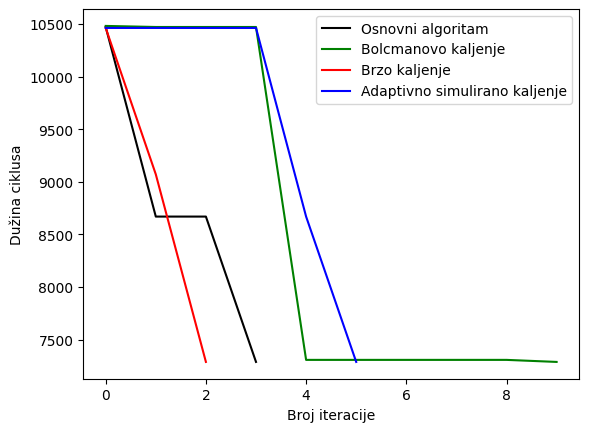

In [362]:
fig, ax = plt.subplots()
ax.plot(range(len(osnovni5res)), osnovni5res, color = 'black', label='Osnovni algoritam')
ax.plot(range(len(boltzmann5res)), boltzmann5res, color = 'green', label='Bolcmanovo kaljenje')
ax.plot(range(len(fast5res)), fast5res, color = 'red', label='Brzo kaljenje')
ax.plot(range(len(adaptive5res)), adaptive5res, color = 'blue', label='Adaptivno simulirano kaljenje')
ax.set(xlabel='Broj iteracije', ylabel='Dužina ciklusa')
plt.legend()
plt.show()

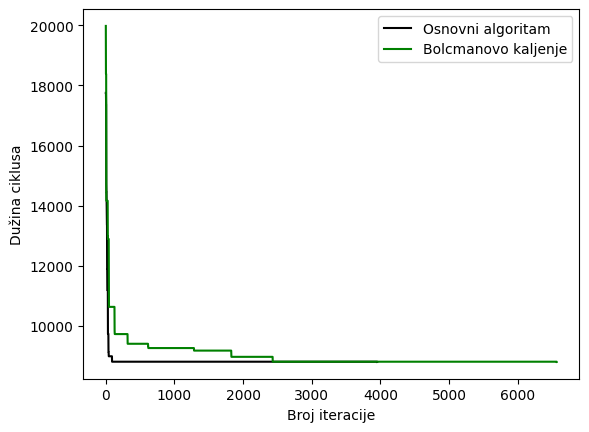

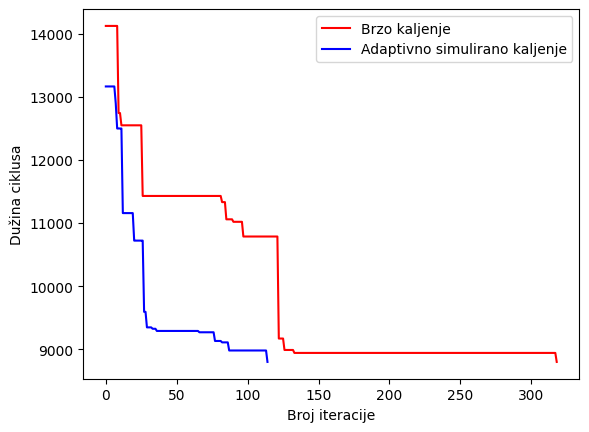

In [364]:
fig, ax = plt.subplots()
ax.plot(range(len(osnovni10res)), osnovni10res, color = 'black', label='Osnovni algoritam')
ax.plot(range(len(boltzmann10res)), boltzmann10res, color = 'green', label='Bolcmanovo kaljenje')
ax.set(xlabel='Broj iteracije', ylabel='Dužina ciklusa')
plt.legend()
plt.show()
fig, ax = plt.subplots()
ax.plot(range(len(fast10res)), fast10res, color = 'red', label='Brzo kaljenje')
ax.plot(range(len(adaptive10res)), adaptive10res, color = 'blue', label='Adaptivno simulirano kaljenje')
ax.set(xlabel='Broj iteracije', ylabel='Dužina ciklusa')
plt.legend()
plt.show()

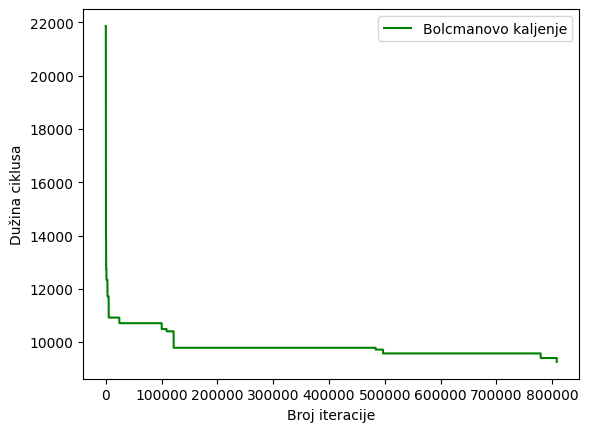

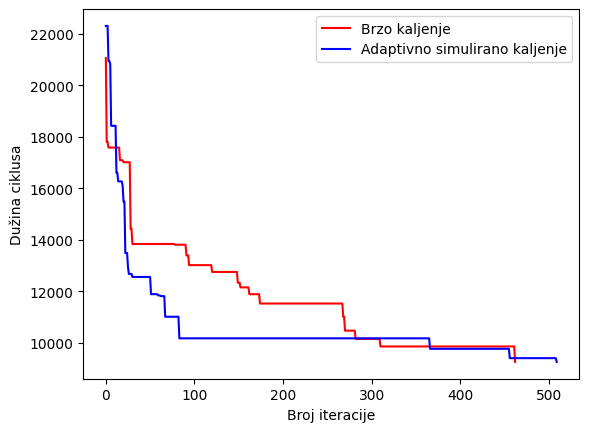

In [366]:
fig, ax = plt.subplots()
ax.plot(range(len(boltzmann15res)), boltzmann15res, color = 'green', label='Bolcmanovo kaljenje')
ax.set(xlabel='Broj iteracije', ylabel='Dužina ciklusa')
plt.legend()
plt.show()
fig, ax = plt.subplots()
ax.plot(range(len(fast15res)), fast15res, color = 'red', label='Brzo kaljenje')
ax.plot(range(len(adaptive15res)), adaptive15res, color = 'blue', label='Adaptivno simulirano kaljenje')
ax.set(xlabel='Broj iteracije', ylabel='Dužina ciklusa')
plt.legend()
plt.show()

In [9]:
berlin = load_data(file_path='berlin52.tsp')

In [10]:
qa = load_data(file_path='qa194.tsp')

============T=1.0==========================
Best cycle:[21, 30, 22, 29, 28, 12, 13, 51, 26, 27, 24, 5, 14, 39, 36, 37, 47, 23, 4, 11, 10, 50, 3, 42, 32, 9, 38, 35, 20, 41, 1, 6, 16, 2, 40, 8, 7, 18, 44, 17, 31, 48, 34, 33, 43, 45, 25, 46, 15, 49, 19, 0]
Best fitness:11178.271548529938
Time:0.7174713509884896
============T=411.2307692307692==========================
Best cycle:[16, 2, 17, 31, 48, 34, 45, 26, 12, 51, 13, 46, 25, 47, 23, 4, 14, 44, 9, 8, 7, 40, 18, 21, 22, 19, 49, 28, 15, 43, 33, 36, 5, 3, 24, 11, 27, 10, 50, 32, 42, 37, 39, 38, 35, 0, 30, 20, 29, 41, 1, 6]
Best fitness:9887.548824788646
Time:0.721376216999488
============T=821.4615384615385==========================
Best cycle:[15, 43, 33, 34, 38, 39, 40, 7, 8, 9, 14, 12, 13, 28, 1, 6, 41, 29, 49, 45, 4, 5, 3, 26, 51, 10, 50, 32, 42, 44, 18, 2, 16, 17, 31, 21, 30, 20, 22, 19, 0, 48, 35, 36, 37, 23, 47, 24, 11, 27, 25, 46]
Best fitness:11659.751033600554
Time:0.7366575219930382
============T=1231.6923076923076============

============T=10667.0==========================
Best cycle:[43, 36, 39, 8, 9, 32, 42, 14, 37, 48, 21, 30, 17, 2, 31, 4, 5, 3, 11, 50, 10, 51, 13, 12, 46, 25, 26, 27, 24, 45, 38, 7, 40, 18, 44, 0, 19, 49, 34, 35, 23, 47, 33, 22, 20, 16, 41, 6, 1, 29, 28, 15]
Best fitness:10252.49291656111
Time:0.7054237529955572
============T=11077.23076923077==========================
Best cycle:[9, 32, 50, 11, 27, 10, 51, 13, 12, 26, 45, 0, 21, 30, 20, 22, 19, 49, 34, 35, 5, 24, 3, 42, 48, 31, 17, 2, 16, 41, 6, 1, 29, 28, 46, 25, 15, 43, 33, 36, 37, 14, 4, 23, 47, 39, 38, 44, 18, 40, 7, 8]
Best fitness:9922.213250703328
Time:0.7043707420089049
============T=11487.461538461539==========================
Best cycle:[33, 38, 36, 23, 47, 45, 15, 28, 49, 19, 29, 1, 6, 41, 22, 21, 0, 43, 24, 11, 27, 26, 25, 46, 13, 12, 51, 10, 50, 32, 42, 17, 30, 20, 16, 2, 14, 3, 5, 4, 37, 39, 9, 8, 7, 40, 18, 44, 31, 48, 35, 34]
Best fitness:9251.189717071833
Time:0.7307238990033511
============T=11897.692307692307========

=======trs 0.0001===tas 100=====rr 10================
Best cycle:[41, 45, 11, 10, 51, 13, 12, 46, 3, 5, 4, 14, 42, 32, 50, 27, 26, 25, 24, 47, 23, 37, 36, 35, 48, 31, 44, 20, 16, 2, 18, 40, 7, 8, 9, 39, 38, 0, 21, 17, 30, 22, 19, 34, 33, 43, 15, 49, 28, 29, 1, 6]
Best fitness:10592.592983628396
Time:0.8655811019998509
=======trs 0.0001===tas 100=====rr 30================
Best cycle:[0, 21, 30, 17, 31, 39, 50, 10, 51, 26, 27, 11, 24, 3, 5, 23, 47, 37, 38, 35, 34, 33, 45, 25, 12, 13, 46, 28, 19, 29, 1, 6, 41, 20, 16, 2, 8, 9, 32, 42, 43, 15, 49, 22, 44, 18, 40, 7, 14, 4, 36, 48]
Best fitness:10612.776761558574
Time:0.8591478419984924
=======trs 0.0001===tas 100=====rr 50================
Best cycle:[22, 19, 49, 29, 41, 6, 1, 28, 46, 25, 27, 24, 47, 45, 15, 43, 21, 0, 34, 33, 39, 36, 37, 23, 4, 14, 5, 3, 42, 9, 8, 7, 38, 35, 48, 31, 44, 18, 40, 32, 50, 10, 51, 13, 12, 26, 11, 2, 16, 17, 30, 20]
Best fitness:10327.598322604452
Time:0.8746629450033652
=======trs 0.0001===tas 1000=====rr 10==

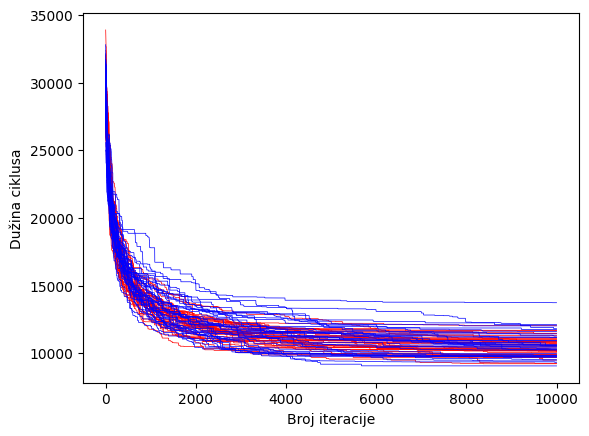

In [11]:
fig, ax = plt.subplots()
for T in np.linspace(1, 16000, 40):
    fastBerlin = SimulatedAnnealing(berlin)
    start = timeit.default_timer()
    fastBerlinRes = fastBerlin.optimize(num_iters=10000, T0=T, fast_annealing=True, end_fitness=0)
    stop = timeit.default_timer()
    print(f'============T={T}==========================')
    print(f'Best cycle:{fastBerlin.cycle}\nBest fitness:{fastBerlin.fitness}\nTime:{stop-start}')
    ax.plot(range(len(fastBerlinRes)), fastBerlinRes, color = 'red', lw=0.5, label='Brzo kaljenje')
    
for trs in (0.00001, 0.0001, 0.001, 0.01):
    for tas in (10, 100, 1000):
        for rr in (10, 30, 50):
            
            adaptiveBerlin = AdaptiveSimulatedAnnealing(berlin)
            adaptiveBerlin.reannealingRate = rr
            adaptiveBerlin.temperature_ratio_scale = trs
            adaptiveBerlin.temperature_anneal_scale = tas
            adaptiveBerlin.calculatec()
            adaptiveBerlin.maxIters = 10000
            start = timeit.default_timer()
            adaptiveBerlinRes = adaptiveBerlin.optimize(end_fitness=0)
            stop = timeit.default_timer()
            print(f'=======trs {trs}===tas {tas}=====rr {rr}================')
            print(f'Best cycle:{adaptiveBerlin.cycle}\nBest fitness:{adaptiveBerlin.fitness}\nTime:{stop-start}')
            ax.plot(range(len(adaptiveBerlinRes)), adaptiveBerlinRes, color = 'blue', lw=0.5, label='Adaptivno simulirano kaljenje')

ax.set(xlabel='Broj iteracije', ylabel='Dužina ciklusa')

plt.show()

============T=1.0==========================
Best cycle:[171, 143, 52, 55, 57, 60, 78, 63, 32, 28, 21, 1, 3, 6, 12, 15, 152, 179, 177, 162, 144, 136, 145, 163, 167, 157, 128, 127, 142, 151, 149, 138, 135, 132, 123, 107, 106, 122, 54, 34, 41, 30, 38, 13, 10, 5, 7, 126, 133, 148, 155, 129, 58, 61, 89, 156, 176, 187, 190, 188, 182, 173, 174, 180, 112, 108, 79, 62, 35, 90, 94, 83, 66, 72, 82, 96, 121, 140, 141, 131, 22, 24, 86, 158, 164, 183, 189, 193, 181, 185, 186, 166, 161, 184, 165, 134, 49, 18, 14, 29, 42, 59, 27, 70, 81, 110, 98, 88, 100, 103, 80, 65, 46, 47, 53, 40, 76, 68, 102, 92, 118, 125, 71, 25, 23, 87, 91, 150, 169, 170, 159, 147, 116, 105, 69, 95, 104, 146, 153, 137, 124, 77, 56, 44, 67, 50, 36, 26, 37, 31, 11, 9, 8, 4, 2, 16, 101, 113, 139, 178, 191, 192, 154, 130, 117, 109, 111, 114, 119, 120, 115, 99, 48, 43, 45, 51, 39, 33, 17, 20, 75, 73, 74, 19, 0, 64, 84, 97, 85, 93, 160, 168, 175, 172]
Best fitness:28514.221904560567
Time:2.6280310340080177
============T=513.7948717948

============T=4616.153846153847==========================
Best cycle:[110, 124, 125, 126, 101, 87, 82, 73, 71, 39, 33, 44, 19, 64, 93, 88, 112, 116, 123, 127, 119, 106, 76, 67, 48, 54, 41, 53, 45, 40, 47, 51, 52, 46, 27, 56, 83, 104, 137, 163, 160, 148, 145, 141, 61, 58, 15, 3, 24, 74, 90, 96, 105, 95, 86, 5, 0, 1, 2, 4, 29, 49, 50, 128, 159, 184, 183, 180, 173, 153, 138, 25, 23, 16, 6, 10, 12, 22, 20, 59, 17, 9, 8, 11, 75, 79, 81, 70, 68, 69, 142, 161, 156, 152, 102, 135, 130, 157, 169, 179, 192, 164, 117, 13, 7, 28, 21, 36, 63, 66, 99, 122, 147, 150, 151, 143, 149, 174, 186, 189, 182, 162, 168, 175, 181, 193, 185, 146, 91, 43, 34, 42, 57, 55, 154, 165, 170, 166, 144, 129, 100, 98, 131, 190, 191, 188, 187, 167, 133, 85, 97, 84, 62, 35, 89, 103, 94, 92, 14, 72, 60, 65, 121, 118, 136, 139, 155, 140, 37, 30, 38, 108, 113, 172, 171, 178, 176, 177, 158, 115, 109, 114, 120, 132, 134, 107, 111, 80, 78, 31, 18, 26, 32, 77]
Best fitness:29043.650049613523
Time:2.583767424992402
============T=5

============T=9231.307692307693==========================
Best cycle:[121, 177, 192, 170, 142, 115, 109, 83, 67, 33, 39, 1, 4, 110, 98, 81, 93, 88, 70, 79, 75, 74, 71, 119, 114, 52, 55, 47, 51, 78, 91, 145, 141, 69, 44, 60, 57, 66, 72, 143, 149, 161, 154, 150, 152, 172, 176, 180, 187, 191, 190, 188, 183, 166, 147, 127, 49, 29, 34, 41, 31, 45, 87, 146, 174, 181, 168, 103, 100, 0, 5, 7, 15, 10, 6, 3, 2, 9, 21, 76, 101, 125, 124, 136, 144, 139, 148, 160, 155, 129, 89, 58, 35, 12, 16, 61, 133, 126, 135, 134, 128, 120, 130, 140, 137, 131, 97, 84, 85, 64, 62, 19, 22, 13, 36, 42, 54, 48, 63, 102, 164, 158, 157, 159, 123, 122, 111, 99, 80, 77, 90, 86, 108, 113, 153, 163, 162, 156, 151, 104, 95, 92, 105, 132, 178, 173, 182, 189, 186, 185, 175, 193, 171, 138, 118, 112, 24, 17, 26, 30, 37, 46, 38, 59, 23, 25, 20, 32, 73, 50, 40, 43, 53, 117, 165, 167, 184, 179, 169, 116, 65, 18, 8, 11, 14, 28, 27, 56, 68, 82, 107, 106, 94, 96]
Best fitness:27848.187522870743
Time:2.7430446479993407
============T=

============T=13846.461538461539==========================
Best cycle:[113, 118, 91, 80, 67, 50, 42, 47, 52, 51, 66, 83, 89, 85, 97, 136, 125, 129, 124, 93, 100, 98, 23, 10, 5, 12, 22, 70, 90, 92, 114, 142, 159, 152, 143, 137, 126, 133, 148, 163, 186, 188, 191, 190, 176, 156, 121, 117, 128, 149, 158, 169, 179, 177, 184, 170, 167, 150, 116, 107, 96, 24, 13, 16, 38, 33, 30, 53, 99, 189, 183, 174, 166, 73, 68, 61, 103, 110, 84, 19, 7, 15, 144, 139, 155, 173, 187, 180, 2, 1, 21, 60, 106, 120, 119, 132, 88, 64, 62, 102, 127, 122, 123, 41, 43, 40, 65, 58, 35, 81, 36, 39, 45, 55, 48, 57, 46, 54, 49, 105, 134, 146, 178, 182, 185, 193, 181, 160, 162, 138, 140, 151, 153, 168, 175, 172, 164, 77, 32, 17, 20, 27, 26, 34, 72, 76, 78, 87, 130, 157, 161, 154, 115, 111, 109, 104, 95, 94, 69, 82, 71, 74, 112, 79, 86, 44, 63, 8, 9, 4, 14, 18, 31, 37, 6, 3, 0, 11, 29, 28, 56, 59, 25, 75, 101, 108, 135, 147, 165, 192, 171, 145, 141, 131]
Best fitness:29274.131601705005
Time:2.5408988059934927
============T

============T=18461.615384615387==========================
Best cycle:[5, 0, 61, 124, 133, 145, 182, 174, 164, 158, 113, 89, 62, 100, 112, 146, 160, 163, 138, 107, 18, 14, 26, 10, 13, 22, 58, 137, 139, 141, 143, 147, 122, 123, 132, 128, 142, 161, 166, 157, 72, 57, 42, 37, 50, 46, 38, 78, 116, 120, 115, 114, 106, 111, 130, 135, 127, 119, 134, 159, 169, 177, 167, 173, 126, 129, 70, 92, 108, 140, 149, 151, 153, 152, 156, 172, 171, 181, 185, 191, 190, 118, 12, 15, 35, 93, 110, 97, 144, 148, 188, 183, 64, 84, 85, 131, 125, 65, 67, 60, 66, 76, 99, 109, 90, 74, 86, 101, 98, 103, 33, 39, 30, 87, 102, 95, 94, 59, 40, 29, 31, 34, 53, 49, 41, 54, 80, 82, 175, 193, 189, 176, 179, 192, 187, 180, 184, 170, 104, 25, 75, 79, 136, 155, 162, 168, 186, 178, 121, 117, 51, 43, 11, 32, 20, 23, 68, 73, 71, 24, 6, 3, 2, 17, 36, 83, 96, 105, 77, 16, 1, 4, 9, 8, 154, 165, 150, 91, 69, 63, 27, 28, 21, 45, 55, 52, 47, 48, 44, 56, 81, 88, 19, 7]
Best fitness:30109.667400021677
Time:2.6257596089999424
============T

=======trs 1e-05===tas 100=====rr 50================
Best cycle:[13, 16, 63, 76, 69, 82, 102, 108, 112, 121, 140, 190, 191, 181, 175, 113, 70, 77, 115, 120, 135, 159, 166, 157, 154, 147, 169, 176, 180, 183, 189, 193, 186, 182, 173, 43, 47, 51, 42, 73, 71, 104, 161, 174, 187, 192, 184, 91, 80, 31, 33, 38, 60, 78, 92, 96, 138, 137, 118, 87, 39, 40, 29, 14, 75, 162, 168, 155, 133, 131, 124, 98, 93, 56, 59, 46, 50, 139, 148, 160, 163, 185, 178, 171, 172, 57, 48, 54, 49, 41, 83, 122, 123, 119, 127, 134, 132, 128, 117, 100, 88, 64, 19, 0, 5, 7, 21, 30, 37, 66, 152, 145, 144, 136, 103, 97, 84, 85, 25, 11, 9, 8, 4, 74, 86, 90, 101, 125, 129, 126, 81, 15, 12, 10, 24, 111, 114, 116, 110, 89, 61, 22, 23, 32, 6, 3, 1, 2, 53, 52, 72, 109, 156, 188, 177, 170, 165, 142, 106, 107, 105, 95, 94, 55, 45, 34, 18, 26, 28, 44, 36, 67, 99, 130, 150, 179, 167, 153, 149, 151, 164, 158, 146, 143, 141, 79, 68, 65, 27, 17, 20, 62, 35, 58]
Best fitness:29355.854827919153
Time:3.022938495996641
=======trs 1e-05===t

=======trs 0.0001===tas 100=====rr 50================
Best cycle:[133, 131, 136, 63, 60, 42, 33, 46, 50, 65, 72, 83, 56, 92, 153, 149, 143, 146, 154, 135, 130, 122, 51, 43, 54, 52, 59, 73, 68, 32, 2, 6, 74, 174, 185, 186, 182, 167, 166, 161, 188, 190, 187, 189, 193, 159, 127, 111, 55, 47, 66, 170, 177, 172, 173, 180, 184, 165, 94, 99, 82, 91, 121, 138, 175, 181, 171, 168, 162, 163, 157, 158, 164, 156, 148, 129, 113, 22, 79, 81, 160, 155, 178, 191, 179, 169, 117, 75, 24, 5, 3, 61, 124, 145, 137, 134, 128, 120, 107, 106, 112, 85, 84, 35, 58, 70, 77, 87, 96, 105, 116, 115, 95, 23, 17, 21, 30, 53, 49, 48, 41, 31, 29, 34, 119, 132, 123, 109, 10, 1, 0, 110, 118, 150, 147, 142, 114, 104, 100, 88, 93, 103, 108, 86, 101, 152, 192, 183, 176, 151, 140, 102, 71, 44, 78, 76, 38, 45, 40, 14, 18, 11, 4, 8, 9, 28, 27, 36, 26, 20, 25, 64, 19, 97, 98, 89, 62, 7, 15, 12, 13, 16, 126, 139, 144, 141, 90, 80, 67, 39, 37, 57, 69, 125]
Best fitness:29526.035142042296
Time:3.4328390349983238
=======trs 0.0001=

=======trs 0.001===tas 100=====rr 50================
Best cycle:[146, 121, 105, 91, 96, 92, 86, 108, 62, 19, 74, 59, 23, 56, 44, 60, 72, 123, 159, 184, 170, 120, 83, 76, 68, 79, 133, 124, 136, 168, 182, 185, 189, 153, 93, 88, 100, 110, 155, 141, 160, 139, 144, 129, 113, 112, 131, 137, 167, 157, 161, 142, 135, 75, 71, 77, 36, 54, 57, 37, 26, 6, 17, 11, 14, 18, 29, 33, 2, 3, 1, 70, 81, 126, 125, 102, 94, 109, 114, 119, 128, 132, 103, 61, 35, 145, 148, 149, 117, 104, 99, 21, 28, 45, 52, 41, 172, 174, 183, 192, 191, 187, 188, 190, 186, 171, 193, 175, 181, 156, 140, 151, 116, 115, 122, 127, 147, 176, 177, 179, 180, 165, 134, 43, 48, 31, 30, 42, 51, 39, 65, 27, 32, 69, 107, 106, 15, 5, 0, 7, 13, 20, 8, 4, 9, 47, 53, 34, 40, 38, 66, 55, 58, 64, 85, 84, 89, 78, 46, 49, 50, 67, 73, 24, 22, 12, 16, 10, 25, 138, 154, 130, 111, 95, 90, 82, 80, 63, 87, 101, 98, 97, 118, 158, 164, 166, 178, 173, 162, 163, 143, 152, 169, 150]
Best fitness:28582.22076663872
Time:3.078923914988991
=======trs 0.001===ta

=======trs 0.01===tas 100=====rr 50================
Best cycle:[79, 101, 88, 107, 156, 142, 90, 22, 7, 10, 20, 127, 183, 161, 165, 192, 110, 3, 1, 71, 181, 176, 160, 129, 24, 118, 178, 170, 159, 85, 104, 40, 42, 50, 80, 12, 4, 31, 60, 92, 83, 51, 148, 144, 162, 139, 177, 18, 63, 23, 67, 47, 108, 154, 122, 93, 62, 5, 66, 55, 49, 54, 45, 16, 73, 82, 68, 96, 37, 76, 13, 61, 65, 72, 99, 105, 151, 143, 115, 38, 17, 57, 102, 128, 135, 48, 87, 116, 113, 97, 74, 112, 89, 84, 41, 39, 26, 36, 59, 29, 14, 9, 28, 56, 30, 32, 8, 33, 11, 34, 70, 69, 27, 53, 46, 91, 123, 163, 167, 168, 141, 44, 25, 86, 78, 58, 121, 140, 153, 136, 124, 117, 172, 182, 133, 125, 95, 134, 130, 81, 35, 19, 6, 100, 149, 175, 189, 174, 103, 98, 21, 152, 157, 171, 193, 186, 137, 138, 158, 191, 180, 147, 179, 184, 131, 145, 173, 190, 187, 164, 188, 185, 109, 94, 114, 132, 150, 169, 166, 146, 111, 106, 77, 64, 0, 2, 15, 43, 52, 120, 119, 155, 126, 75]
Best fitness:49890.57040422368
Time:2.9267129609943368
=======trs 0.01===tas

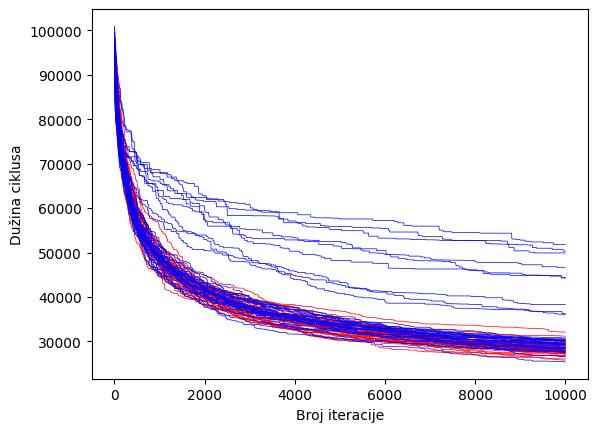

In [12]:
fig, ax = plt.subplots()
for T in np.linspace(1, 20000, 40):
    fastQatar = SimulatedAnnealing(qa)
    start = timeit.default_timer()
    fastQatarRes = fastQatar.optimize(num_iters=10000, T0=T, fast_annealing=True, end_fitness=0)
    stop = timeit.default_timer()
    print(f'============T={T}==========================')
    print(f'Best cycle:{fastQatar.cycle}\nBest fitness:{fastQatar.fitness}\nTime:{stop-start}')
    ax.plot(range(len(fastQatarRes)), fastQatarRes, color = 'red', lw=0.5)
    
for trs in (0.00001, 0.0001, 0.001, 0.01):
    for tas in (10, 100, 1000):
        for rr in (10, 30, 50):
            
            adaptiveQatar = AdaptiveSimulatedAnnealing(qa)
            adaptiveQatar.reannealingRate = rr
            adaptiveQatar.temperature_ratio_scale = trs
            adaptiveQatar.temperature_anneal_scale = tas
            adaptiveQatar.calculatec()
            adaptiveQatar.maxIters = 10000
            start = timeit.default_timer()
            adaptiveQatarRes = adaptiveQatar.optimize(end_fitness=0)
            stop = timeit.default_timer()
            print(f'=======trs {trs}===tas {tas}=====rr {rr}================')
            print(f'Best cycle:{adaptiveQatar.cycle}\nBest fitness:{adaptiveQatar.fitness}\nTime:{stop-start}')
            ax.plot(range(len(adaptiveQatarRes)), adaptiveQatarRes, color = 'blue', lw=0.5)

ax.set(xlabel='Broj iteracije', ylabel='Dužina ciklusa')

plt.show()